In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Activation, Flatten, Dropout, LeakyReLU, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import os
from numpy import genfromtxt

Using TensorFlow backend.


In [2]:
def read_ecg(file_name):
    return genfromtxt(file_name, delimiter=',')

In [3]:
np_data = read_ecg('./input/clean_ecg.csv')
np_data2 = read_ecg('./input/noise_ecg.csv')

In [4]:
split_percent = 0.8

In [5]:
x_train = np_data[0 : int((np_data.shape[0]) * split_percent)]
x_test = np_data[int(np_data.shape[0] * split_percent): ]

xtrainn = np_data2[0 : int((np_data2.shape[0]) * split_percent)]
xtestn = np_data2[int(np_data2.shape[0] * split_percent): ]


print(x_test.shape)
print(xtrainn.shape)

(780, 2000)
(3120, 2000)


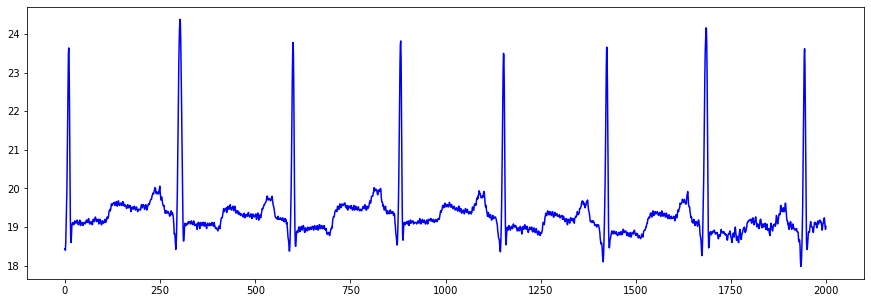

In [6]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[200], 'b')
plt.show()

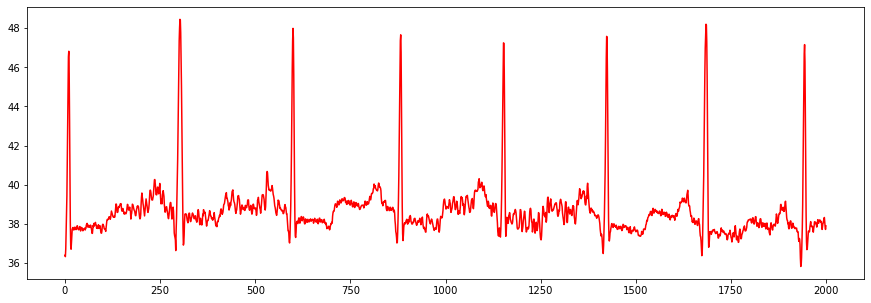

In [7]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(xtestn[200], 'r')
plt.show()

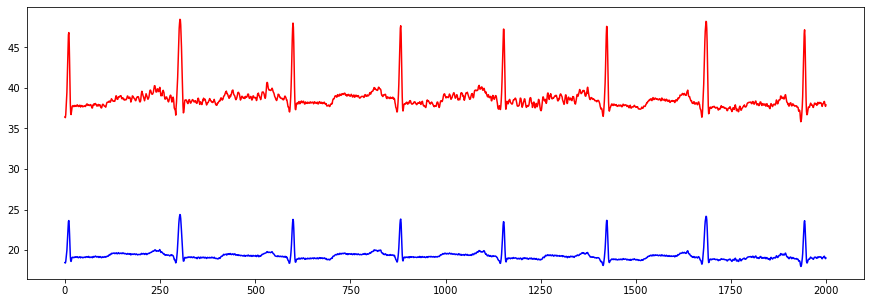

In [8]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(xtestn[200], 'r')
ax.plot(x_test[200], 'b')
plt.show()

In [9]:
x_train_noisy = np.asarray(xtrainn)
x_test_noisy = np.asarray(xtestn)

In [10]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)


def make_positive(data):
    a = []
    for n in data:
        min_val = min(n)
        u = [(x + abs(min_val)) for x in n]
        a.append(u)
    return a

In [11]:
x_train = normalized(x_train,1)
x_test = normalized(x_test,1)
x_train_noisy = normalized(x_train_noisy,1)
x_test_noisy = normalized(x_test_noisy, 1)

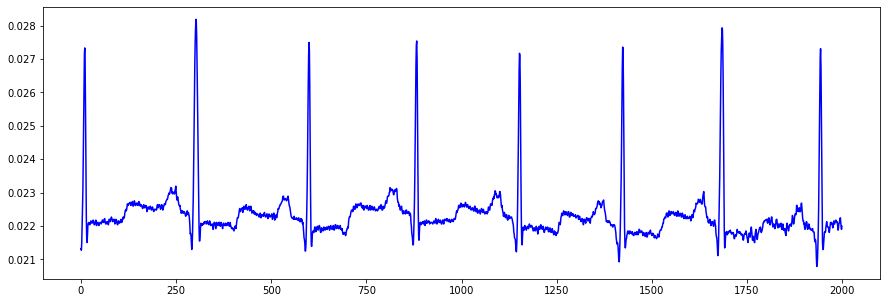

In [12]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[200], 'b')
plt.show()

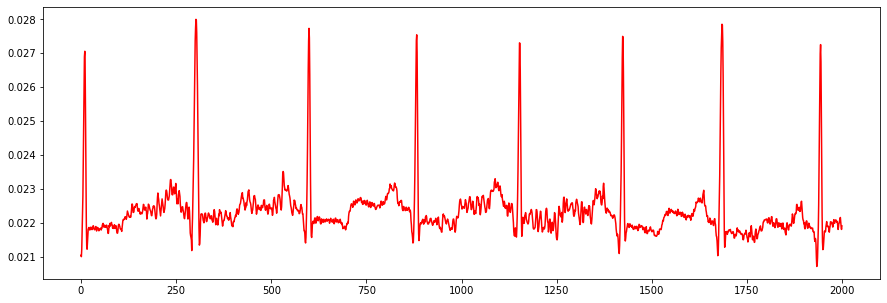

In [13]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test_noisy[200], 'r')
plt.show()

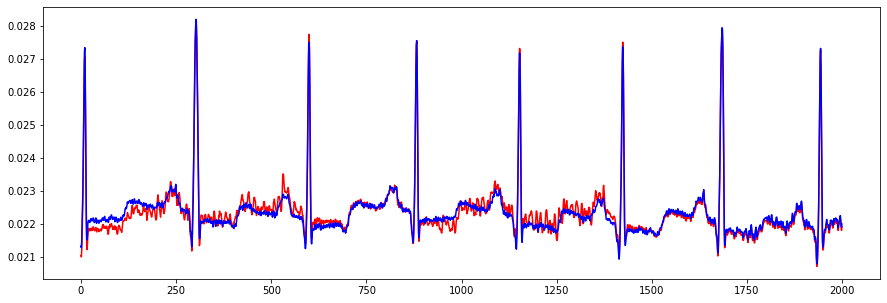

In [14]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test_noisy[200], 'r')
ax.plot(x_test[200], 'b')
plt.show()

In [15]:
print(f"X Train shape: {x_train.shape}")
print(f"X Test shape: {x_test.shape}")
print(f"X Noisy Train shape: {x_train_noisy.shape}")

X Train shape: (3120, 2000)
X Test shape: (780, 2000)
X Noisy Train shape: (3120, 2000)


In [16]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_noisy = x_train_noisy.reshape((x_train_noisy.shape[0],x_train_noisy.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
x_test_noisy = x_test_noisy.reshape((x_test_noisy.shape[0],x_test_noisy.shape[1],1))


In [17]:
print(x_train.shape)
print(x_train_noisy.shape)
print(x_test.shape)
print(x_test_noisy.shape)

(3120, 2000, 1)
(3120, 2000, 1)
(780, 2000, 1)
(780, 2000, 1)


In [18]:
print(x_train.shape)

(3120, 2000, 1)


In [19]:
input_img = Input(shape=(x_train.shape[1],1))


x = Conv1D(40, 16, activation="relu", padding='same', name='encoder1')(input_img)
x = MaxPooling1D(2, padding='same',name='down1')(x) 
x = Conv1D(40, 16, activation="relu", padding='same',name='encoder2')(x)
x = MaxPooling1D(2, padding='same',name='down2')(x) 
x = Conv1D(20, 16, activation="relu", padding='same',name='encoder3')(x)



x = Conv1D(20, 16, activation="relu", padding='same',name='decoder1')(x)
x = UpSampling1D(2, name='up1')(x)
x = Conv1D(40, 16, activation="relu", padding='same',name='decoder2')(x)
x = UpSampling1D(2, name='up2')(x)
x = Conv1D(40, 16, activation="relu", padding='same',name='decoder3')(x)


out = Conv1D(1, 1, activation="sigmoid")(x)

autoencoder = Model(input_img, out)

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000, 1)           0         
_________________________________________________________________
encoder1 (Conv1D)            (None, 2000, 40)          680       
_________________________________________________________________
down1 (MaxPooling1D)         (None, 1000, 40)          0         
_________________________________________________________________
encoder2 (Conv1D)            (None, 1000, 40)          25640     
_________________________________________________________________
down2 (MaxPooling1D)         (None, 500, 40)           0         
_________________________________________________________________
encoder3 (Conv1D)            (None, 500, 20)           12820     
_________________________________________________________________
decoder1 (Conv1D)            (None, 500, 20)           6420

In [20]:
from keras.optimizers import *
autoencoder.compile(optimizer=Adam(lr=0.001),
                    loss='mse',
                    metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = autoencoder.fit(x_train_noisy, x_train,
    epochs = 100,
    batch_size = 32,
    shuffle = True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[es])

Train on 3120 samples, validate on 780 samples
Epoch 1/100
3120/3120 [==============================] - 7s 2ms/step - loss: 0.0267 - accuracy: 0.0000e+00 - val_loss: 4.9984e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
3120/3120 [==============================] - 3s 923us/step - loss: 4.9984e-04 - accuracy: 0.0000e+00 - val_loss: 4.9984e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
3120/3120 [==============================] - 3s 906us/step - loss: 4.9983e-04 - accuracy: 0.0000e+00 - val_loss: 4.9983e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
3120/3120 [==============================] - 3s 931us/step - loss: 4.9983e-04 - accuracy: 0.0000e+00 - val_loss: 4.9982e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
3120/3120 [==============================] - 3s 934us/step - loss: 4.9982e-04 - accuracy: 0.0000e+00 - val_loss: 4.9982e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
3120/3120 [==============================] - 3s 910us/step - loss: 4.9981e-04 - accuracy: 0.0000e+00 - val_loss: 4.9980e-04 - val_ac

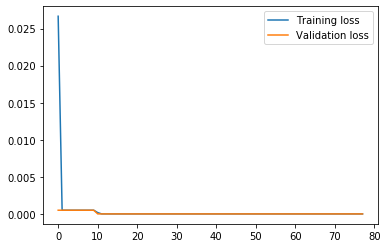

In [22]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()

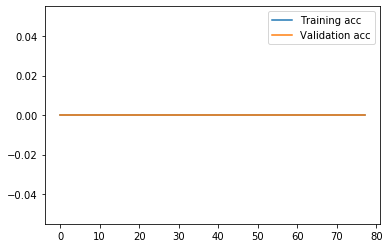

In [23]:
plt.plot(history.history["accuracy"], label="Training acc")
plt.plot(history.history["val_accuracy"], label="Validation acc")
plt.legend()

In [24]:
decoded_imgs = autoencoder.predict(x_test_noisy)
decoded_imgs.shape

(780, 2000, 1)

In [25]:
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0],
                                      x_train_noisy.shape[1])

decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],
                                    decoded_imgs.shape[1])

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])

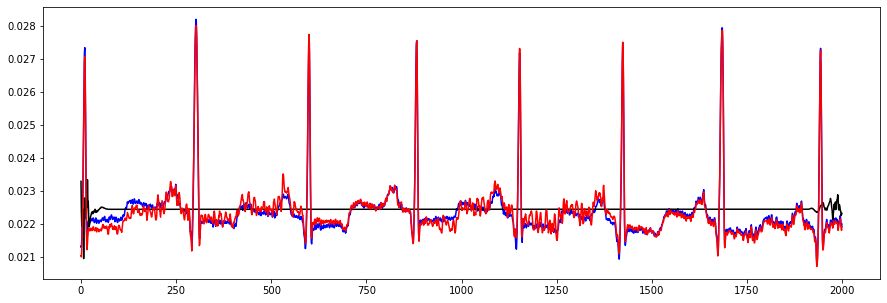

In [26]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[200], 'b', label='Clean')
ax.plot(decoded_imgs[200], 'k', label='Decoded')   
ax.plot(x_test_noisy[200], 'r', label='Noise')
plt.show()

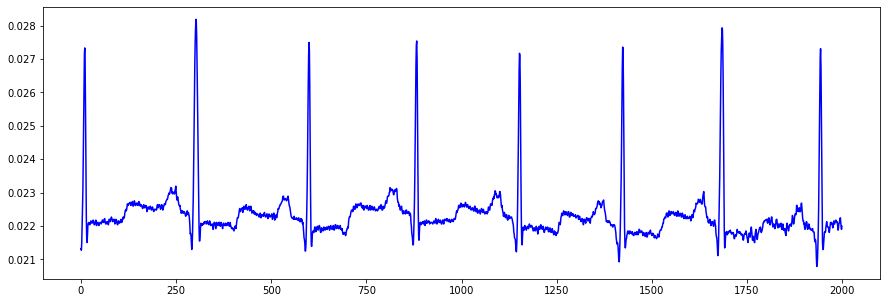

In [27]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[200], 'b', label='Clean')
plt.show()

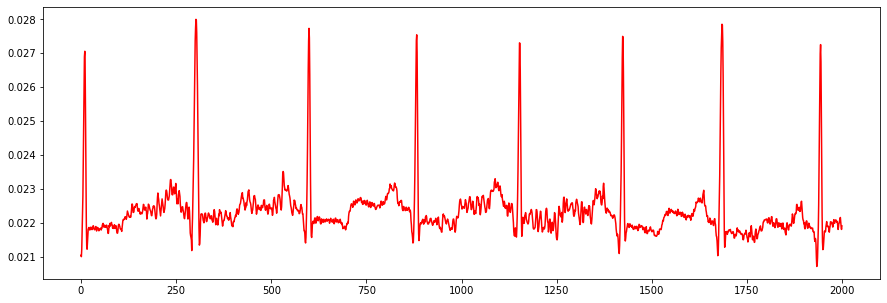

In [28]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test_noisy[200], 'r', label='Noise')
plt.show()

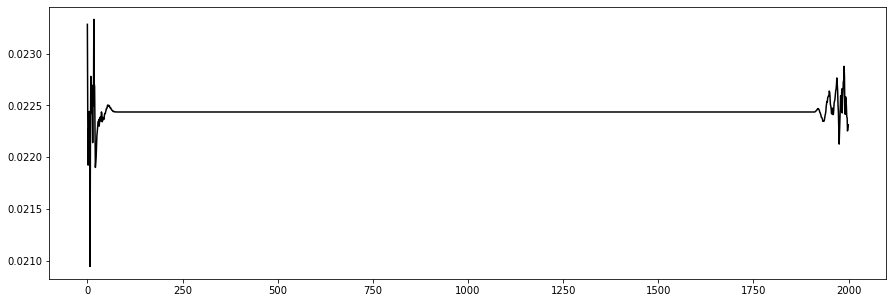

In [29]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(decoded_imgs[200], 'k', label='Decoded')   
plt.show()